In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('mmm.csv', parse_dates=['Date'], index_col='Date')
df.head()

,TV,Radio,Banners,Sales
Date,,,,
2018-01-07,13528.1,0.00,0.00,9779.80
2018-01-14,0.0,5349.65,2218.93,13245.19
2018-01-21,0.0,4235.86,2046.96,12022.66
2018-01-28,0.0,3562.21,0.00,8846.95
2018-02-04,0.0,0.00,2187.29,9797.07


<AxesSubplot:>

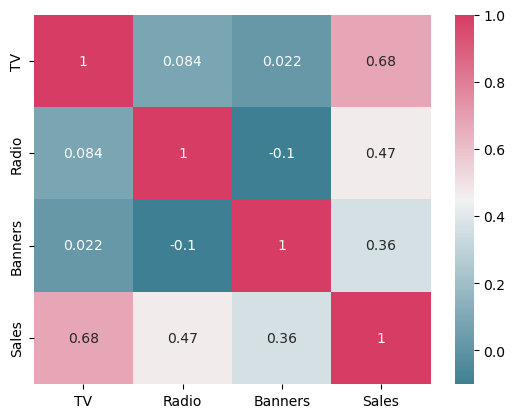

In [11]:
#EDA
import seaborn as sns
#plot 1, correlation matrix
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels = corr.columns, 
            annot=True, cmap = sns.diverging_palette(220, 2, as_cmap=True))

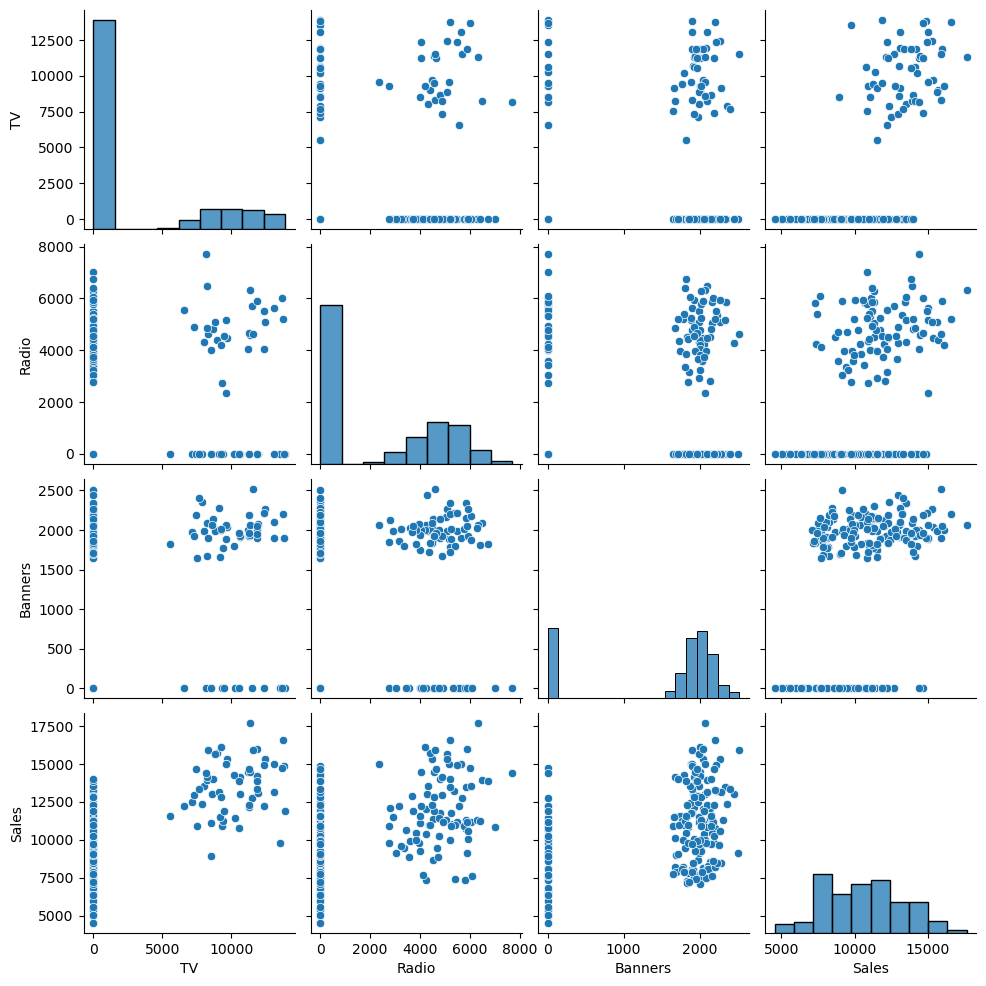

In [12]:
#pairplot
sns.pairplot(df)

In [8]:
#sales = f(TV) + g(Radio) + h(Banners) + Baseline

#because modelling must be additive, we usually use simpler models, linear models

#Modelling with linear Regression

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

X = df.iloc[:, :-1]
y = df.iloc[:, -1]

lr = LinearRegression()

print(cross_val_score(lr, X, y, cv=TimeSeriesSplit()))

[0.69594303 0.69302285 0.66850729 0.78807363 0.73512387]


In [9]:
lr.fit(X, y)

print('coefficients:', lr.coef_)
print('Intercept:', lr.intercept_)

coefficients: [0.35968382 0.48833246 1.2159193 ]
Intercept: 6678.396933606161


In [10]:
#lets use OLS here instead, results should be the same with more details
import statsmodels.formula.api as sm
model = sm.ols(formula='Sales~TV+Radio+Banners', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     234.8
Date:                Wed, 01 Nov 2023   Prob (F-statistic):           1.28e-64
Time:                        22:17:34   Log-Likelihood:                -1711.1
No. Observations:                 200   AIC:                             3430.
Df Residuals:                     196   BIC:                             3443.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6678.3969    209.575     31.866      0.0

In [13]:
#consider the week pf 2021-10-10 and predict using linear regression model
print(lr.predict(([[11543.58, 4615.35, 2518.88]])))

[16147.01594158]


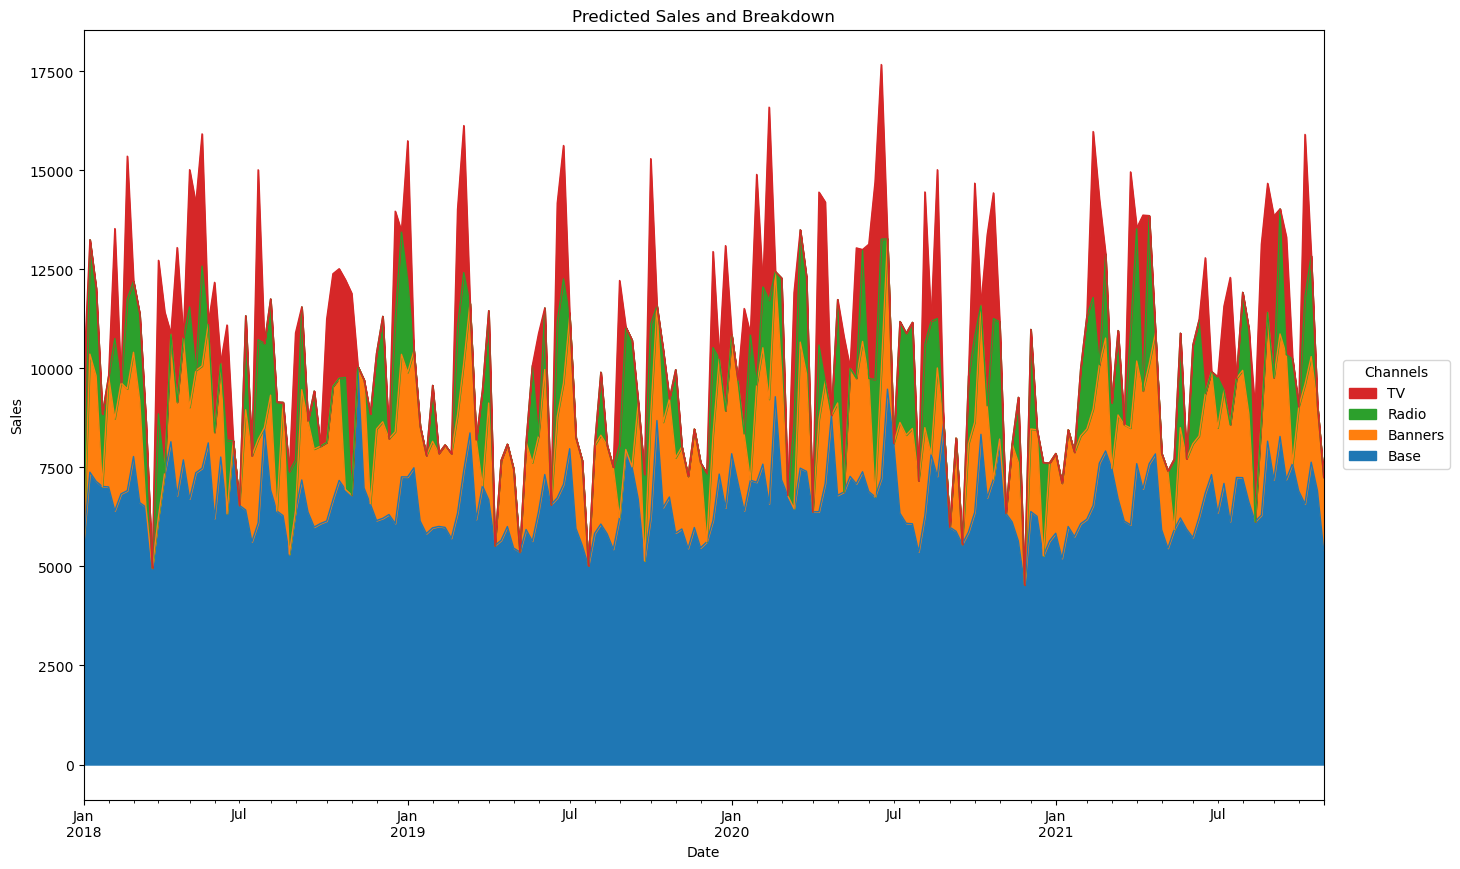

In [24]:
#in reality the sales should be equal to 15904.11
#since it does not, we can get a correction factor by saying 15904.11/16147.016 ~ 0.985
#we can then apply this correction factor to each of the calculations of the individual sales per ad spend
#e.g for TV, the sales will be coef_TV*spendings_TV*correction_factor

#to generate a contribution plot for all observations like this we do the following:

weights = pd.Series(
    lr.coef_,
    index=X.columns
)

base = lr.intercept_

#get unadjusted contributions
unadj_contributions = X.mul(weights).assign(Base=base)
#this takes the actual sales and divides by sums the predicted sales row wise and then multiplies each col by the corr_fac
adj_contributions = (unadj_contributions
                      .div(unadj_contributions.sum(axis=1), axis=0)
                      .mul(y, axis=0)) 

ax = (adj_contributions[["Base", "Banners", "Radio", "TV"]]
     .plot.area(
         figsize=(16,10),
         linewidth=1,
         title='Predicted Sales and Breakdown',
         ylabel='Sales',
         xlabel='Date')
     )

handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1], labels[::-1],
    title= 'Channels', loc="center left",
    bbox_to_anchor=(1.01, 0.5)
)

In [25]:
#next we can compute return on investment (ROI) from Ad spends

#channel_ROI = Sales from the channel / channel spendings

#for TV ROI
sales_from_tv = adj_contributions['TV'].sum()
spendings_on_tv = df['TV'].sum()
tv_roi = sales_from_tv / spendings_on_tv
tv_roi

#note ROI must be > 1 to make any sense, othewise we are earning less than what we spend on ads


0.36024500713553126

In [28]:
sales = adj_contributions[["TV", "Radio", "Banners"]].sum()
spend = df[["TV", "Radio", "Banners"]].sum()

roi = sales / spend
roi

TV         0.360245
Radio      0.489496
Banners    1.214728
dtype: float64

Note the following problems with the above approach
1. Performance could be better, model is super simplistic and we can try to engineer some more feature to do better predictions
2. The model does not reflect reality, false assumption that the more you invest in one ad form, the more sales you will get, when in reality this is not true and there is a saturation point.
3. Optimizing based on 2 is unrealistic and a waste of time in most cases